In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Binarizer, LabelEncoder, MultiLabelBinarizer, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, accuracy_score, precision_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from scipy.stats import ttest_rel, ttest_ind
from scipy import stats
from keras.layers import Input, GRU, GlobalMaxPooling1D, GlobalAveragePooling1D, Lambda, concatenate, Dense, Dropout
from keras.models import Model, load_model
from keras import backend as K
import tensorflow as tf
import cms_preprocess

2023-03-16 14:34:27.666223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 14:34:27.710712: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/local-scratch/localhome/ada104/orx/cms_preprocess.py:17: DtypeWarning: Columns (1,3,21) have mixed types. Specify dtype option on import or set low_memory=False.
  ben = pd.read_csv("/localhome/ada104/orx/data/cms/ben.csv",
/local-scratch/localhome/ada104/orx/cms_preprocess.py:19: DtypeWarning: Columns (1,3,30) have mixed t

In [2]:
train_input, test_input, train_target, test_target, train_dv, test_dv = cms_preprocess.get_mhe(beneficiaries_df=cms_preprocess.ben,
                                                 inpatient_df=cms_preprocess.ip, dx = cms_preprocess.dx, pcs= cms_preprocess.pcs, 
                                                              start_year=2008, end_year=2010, rows = 10000, random_state = 42)

In [3]:
# train_input = np.load('/localhome/ada104/orx/data/cms/train_inp.npy')
# train_input = train_input.astype('float32')

# train_dv = np.load('/localhome/ada104/orx/data/cms/train_dv.npy')
# train_dv = train_dv

# train_target = np.load('/localhome/ada104/orx/data/cms/train_tar.npy')
# train_target = train_target.astype('float32')

In [4]:
train_input = np.load('/localhome/ada104/orx/data/cms/train_inp_balanced.npy')
train_input = train_input.astype('float32')

train_dv = np.load('/localhome/ada104/orx/data/cms/train_dv_balanced.npy')
train_dv = train_dv

train_target = np.load('/localhome/ada104/orx/data/cms/train_tar_balanced.npy')
train_target = train_target.astype('float32')

In [18]:
np.save('/localhome/ada104/orx/data/cms/train_inp_balanced.npy', train_input.astype(bool))
np.save('/localhome/ada104/orx/data/cms/train_dv_balanced.npy', train_dv)
np.save('/localhome/ada104/orx/data/cms/test_inp_balanced.npy', test_input.astype(bool))
np.save('/localhome/ada104/orx/data/cms/test_dv_balanced.npy', test_dv)
np.save('/localhome/ada104/orx/data/cms/test_tar_balanced.npy', test_target.astype(bool))
np.save('/localhome/ada104/orx/data/cms/train_tar_balanced.npy', train_target.astype(bool))

In [19]:
np.where(train_target==1)[0]

array([  46,   53,  138,  255,  344,  421,  741,  915,  925,  945, 1133,
       1140, 1145, 1329, 1337, 1462, 1464, 1465, 1481, 1489, 1513, 1530,
       1545, 1564, 1680, 1709, 1784, 1883, 1892, 1940, 1947, 2071, 2104,
       2178, 2205, 2209, 2350, 2551, 2693, 2876, 2916, 2984, 3453, 3495,
       3540, 3673, 3694, 3777, 3792, 3893, 3972])

In [3]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Define the model
    data_input = tf.keras.layers.Input(shape=(None, 516))  # input shape for non-demographic variables data
    feature_input = tf.keras.layers.Input(shape=(2,))  # input shape for demographic variables
    x = tf.keras.layers.GRU(200, return_sequences=True, dropout=0.2)(data_input)  # GRU layer with 200 hidden units and dropout rate of 0.2
    x_max = tf.keras.layers.GlobalMaxPooling1D()(x)  # max pooling over the time dimension
    x_avg = tf.keras.layers.GlobalAveragePooling1D()(x)  # average pooling over the time dimension
    x_min = tf.keras.layers.Lambda(lambda t: -1 * tf.keras.backend.max(-1 * t, axis=1))(x)  # min pooling over the time dimension
    x = tf.keras.layers.concatenate([x_max, x_avg, x_min])  # concatenate the pooled outputs
    x = tf.keras.layers.Dropout(0.2)(x)  # dropout layer to prevent overfitting
    concatenated = tf.keras.layers.concatenate([x, feature_input])  # concatenate the demographic variables with the pooled output
    output = tf.keras.layers.Dense(1, activation='sigmoid')(concatenated)  # dense, fully connected layer with a sigmoid activation
    model = tf.keras.Model(inputs=[data_input, feature_input], outputs=output)  # define the model with inputs and outputs

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Define the number of chunks
    num_chunks = 30

    # Calculate the size of each chunk
    chunk_size = train_input.shape[0] // num_chunks

    # Train the model in chunks
    for i in range(num_chunks):
        start_index = i * chunk_size
        end_index = start_index + chunk_size
        if i == num_chunks - 1:
            end_index = train_input.shape[0]

        chunk_data = train_input[start_index:end_index]
        chunk_features = train_dv[start_index:end_index]
        chunk_target = train_target[start_index:end_index]

        model.fit([chunk_data, chunk_features], chunk_target, epochs=10, batch_size=250)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-03-16 14:35:09.897795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 14:35:09.912409: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 14:35:09.912551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 14:35:09.912996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable the

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Define the model
    data_input = tf.keras.layers.Input(shape=(None, 516))  # input shape for non-demographic variables data
    feature_input = tf.keras.layers.Input(shape=(2,))  # input shape for demographic variables
    x = tf.keras.layers.GRU(200, return_sequences=True, dropout=0.2)(data_input)  # GRU layer with 200 hidden units and dropout rate of 0.2
    x_max = tf.keras.layers.GlobalMaxPooling1D()(x)  # max pooling over the time dimension
    x_avg = tf.keras.layers.GlobalAveragePooling1D()(x)  # average pooling over the time dimension
    x_min = tf.keras.layers.Lambda(lambda t: -1 * tf.keras.backend.max(-1 * t, axis=1))(x)  # min pooling over the time dimension
    x = tf.keras.layers.concatenate([x_max, x_avg, x_min])  # concatenate the pooled outputs
    x = tf.keras.layers.Dropout(0.2)(x)  # dropout layer to prevent overfitting
    concatenated = tf.keras.layers.concatenate([x, feature_input])  # concatenate the demographic variables with the pooled output
    output = tf.keras.layers.Dense(1, activation='sigmoid')(concatenated)  # dense, fully connected layer with a sigmoid activation
    model = tf.keras.Model(inputs=[data_input, feature_input], outputs=output)  # define the model with inputs and outputs

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Define the number of chunks
    num_chunks = 30

    # Calculate the size of each chunk
    chunk_size = train_input.shape[0] // num_chunks

    # Train the model in chunks
    history = {'loss': [], 'accuracy': []}
    for i in range(num_chunks):
        start_index = i * chunk_size
        end_index = start_index + chunk_size
        if i == num_chunks - 1:
            end_index = train_input.shape[0]

        chunk_data = train_input[start_index:end_index]
        chunk_features = train_dv[start_index:end_index]
        chunk_target = train_target[start_index:end_index]

        hist = model.fit([chunk_data, chunk_features], chunk_target, epochs=10, batch_size=250)
        
        history['loss'].extend(hist.history['loss'])
        history['accuracy'].extend(hist.history['accuracy'])
    
    # Plot the learning curve
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(range(1, len(history['loss']) + 1), history['loss'], label='Training Loss')
    ax.plot(range(1, len(history['accuracy']) + 1), history['accuracy'], label='Training Accuracy')
    ax.set_xlabel('Number of iterations')
    ax.set_ylabel('Loss / Accuracy')
    ax.legend()
    plt.show()

In [8]:
# test_input = np.load('/localhome/ada104/orx/data/cms/test_inp.npy')
# test_input = test_input.astype('float32')

# test_dv = np.load('/localhome/ada104/orx/data/cms/test_dv.npy')

# test_target = np.load('/localhome/ada104/orx/data/cms/test_tar.npy')
# test_target = test_target.astype('float32')

In [9]:
test_input = np.load('/localhome/ada104/orx/data/cms/test_inp_balanced.npy')
test_input = test_input.astype('float32')

test_dv = np.load('/localhome/ada104/orx/data/cms/test_dv_balanced.npy')

test_target = np.load('/localhome/ada104/orx/data/cms/test_tar_balanced.npy')
test_target = test_target.astype('float32')

In [21]:
# Set batch size and number of chunks
batch_size = 8
num_chunks = 30

# Split test data and demographic variables into chunks
chunk_size = len(test_input) // num_chunks
test_chunks = [test_input[i:i+chunk_size] for i in range(0, len(test_input), chunk_size)]
feature_chunks = [test_dv[i:i+chunk_size] for i in range(0, len(test_dv), chunk_size)]

# Get predictions for each chunk of data
predictions = []
for i, chunk in enumerate(test_chunks):
    feature_chunk = feature_chunks[i]
    chunk_predictions = model.predict([chunk, feature_chunk], batch_size=batch_size)
    predictions.append(chunk_predictions)

# Concatenate predictions from all chunks
predictions = np.concatenate(predictions, axis=0)


2/2 [==============================] - 0s 5ms/step


In [22]:
np.where(test_target==1)[0]

array([167, 209, 214, 283, 355, 383, 423, 491, 631, 674, 837, 890, 945])

In [23]:
# Get the prediction for some samples in the test set
sample = test_input[np.where(test_target==1)[0]]
dv_sample = test_dv[np.where(test_target==1)[0]]

prediction = model.predict([np.array(sample), dv_sample])

# Print the prediction
print('Prediction:', prediction)

1/1 [==============================] - 0s 37ms/step
Prediction: [[5.4519447e-03]
 [5.4519447e-03]
 [3.2965370e-02]
 [2.0060364e-04]
 [4.0482104e-02]
 [2.0060364e-04]
 [2.9213574e-02]
 [1.1350195e-01]
 [9.6078634e-02]
 [2.1409830e-02]
 [4.9769670e-01]
 [2.5130460e-01]
 [7.2763907e-03]]


In [24]:
preds = np.copy(predictions)
preds = np.squeeze(preds)

# Find the F1 score for different threshold values
thresholds = np.arange(0, 1, 0.01)
f1_scores = [f1_score(test_target, (preds > t).astype(int), average='weighted') for t in thresholds]

# Find the threshold value that maximizes the F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(best_threshold)

preds[preds >= best_threshold] = 1
preds[preds < best_threshold] = 0

0.46


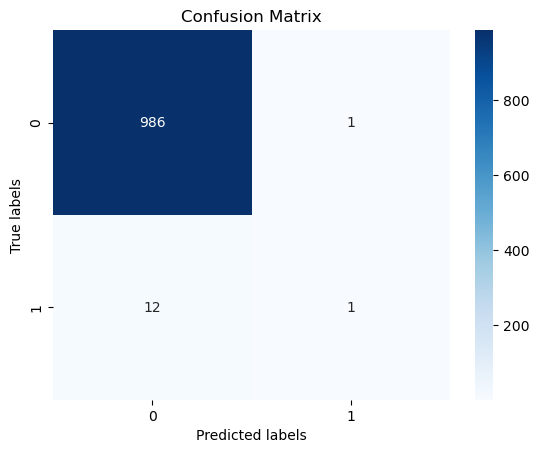

In [25]:
# Compute the confusion matrix
cm = confusion_matrix(test_target, preds)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


AUC: 0.5380
Precision with recall set to 0.9: 0.5000


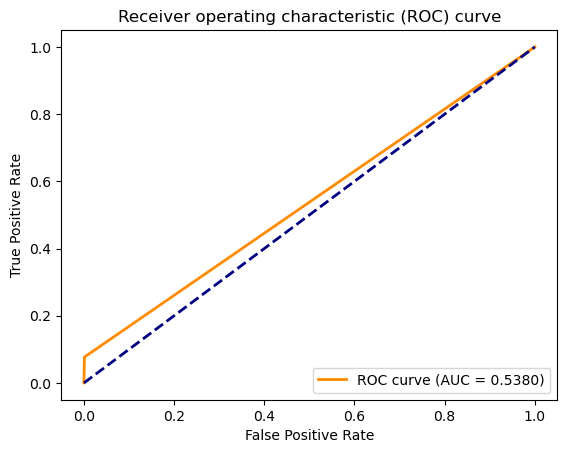

In [26]:
# Compute the AUC
auc_score = roc_auc_score(test_target, preds)
print("AUC: {:.4f}".format(auc_score))

# Compute the precision with recall set to 0.9
precision, recall, thresholds = precision_recall_curve(test_target, preds)
idx = (recall >= 0.9).argmin()
precision_at_recall_09 = precision[idx]
print("Precision with recall set to 0.9: {:.4f}".format(precision_at_recall_09))

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(test_target, preds)

# Compute the area under the curve (AUC)
roc_auc_curve = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc='lower right')
plt.show()
